In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import bisect
sys.path.append('D:/Dropbox/py_projects/customlib/')
import customlib as cl

import numpy as np
import scipy.constants as pc
import pandas as pd

import matplotlib.pyplot as plt

# damage thresholds
---

paper by Stuart et al. 1996 "Nanosecond-to-femtosecond laser-induced breakdown in dielectrics"

For pulse lengths longer than a few picoseconds, the main damage mechanism is through heating. However, for short pulses, the damage is due to electron ionization. The transition from heating to ionization results in higher damage thresholds for shorter pulses than predicted by the heating damage curve.

damage fluence due to heating:
$$ df = c_{norm} * \Tau_{l}^{\alpha} $$ 
- $\Tau_{l}$ is the pulse length
- $\alpha$ is usually in the range of 0.3 - 0.6, with 0.5 being the standard value
- $c_{norm}$ is the normalization constant for the curve. this is usually based on some damage threshold given a specific pulse length e.g. 20 J/cm^2 at 20 ns

In [2]:
def damage_fluence_heating(tlen, normconst, alpha=0.5):
    """
    calculate the damage threshold for a given pulse length 

    alpha = 0.5, usual values are between 0.3-0.6 depending on the surface. 0.5 for sused silica

    return damage fluence threshold in J/cm^2
    """
    damagefluence = normconst * tlen**alpha
    return damagefluence


### damage threshold values
---

Thorlabs beam sampler -B coating (BSF10-B):
- 0.246 J/cm2 (800 nm, 99 fs, 1 kHz, Ø0.166 mm)
- 7.5 J/cm2 (810 nm, 10 ns, 10 Hz, Ø0.133 mm)


In [3]:


damflu = [7.5, 20]
dampulselen = [10.0e-9, 10.0e-9]

normconst = [df / damage_fluence_heating(tlen,1) for df,tlen in zip(damflu,dampulselen)]

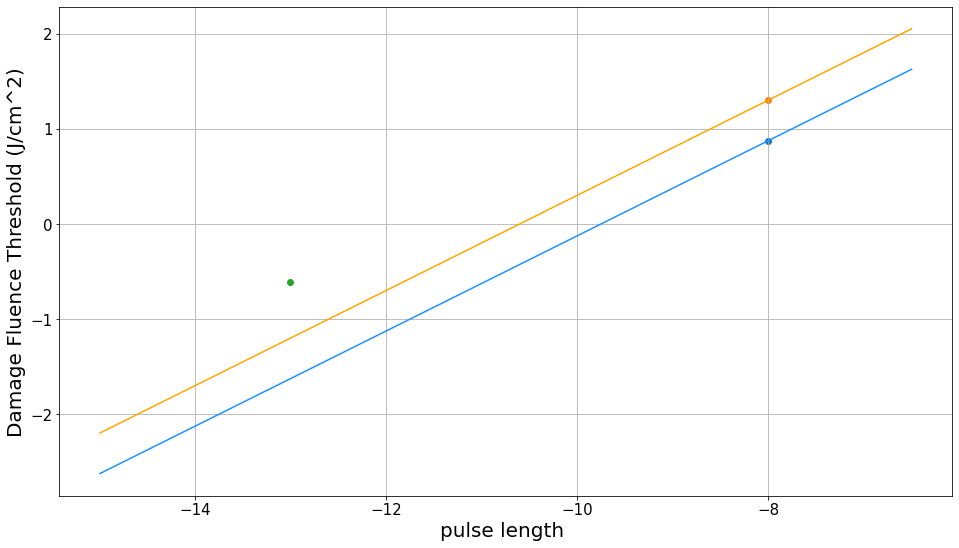

In [4]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(16,9), sharex=True)
colorlist = ['dodgerblue', 'orange', 'tab:green']

yscale = 1

for i,nc in enumerate(normconst):
    ls = dict(linewidth=1.50,linestyle='-',color=colorlist[i],marker='o',ms=0, mfc='None', alpha=1)
    
    xvec = np.arange(-15,-6,0.5)
    tlenvec = 10**(xvec)
    yvec = np.log10( damage_fluence_heating(tlenvec,nc) )
    axs.plot(xvec, yvec,**ls)

    axs.scatter( np.log10(dampulselen[i]), np.log10(damflu[i]) )

axs.scatter( np.log10(99e-15), np.log10(0.246) )


fs = dict(color='k', fontsize=20)
plt.xlabel('pulse length ',**fs)

axs.set_ylabel('Damage Fluence Threshold (J/cm^2)', **fs)

# leglist = ['Air', 'Regen top surface', 'Front-end box air']
# leglist = ['Front-end box', 'Table top']
# axs.legend(leglist, fontsize=18, loc='best')

# axs.set_xticks(np.arange(xmin,xmax, 20*60))
# axs.xaxis.set_major_formatter(timeplotfmt )
# axs.set_yticks(np.arange(0,40,5))
axs.tick_params(labelcolor='k', labelsize=15 )
axs.grid(True)
plt.show()

In [5]:
ENERGY_IR = 25e-3 # Joules. energy of IR pulse
TLEN_IR = 1.1e-12 # sec. pulse length of IR laser
FWHM_X_IR = (2332 - 1237.5)*1e-6 # meter. waist of IR laser out of compressor
FWHM_Y_IR = (1672 - 654.5)*1e-6 # meter. waist of IR laser out of compressor
print(f'FWHM X = {FWHM_X_IR*1e6:0.3f} um')
print(f'FWHM Y = {FWHM_Y_IR*1e6:0.3f} um')

WAIST_X_IR = FWHM_X_IR / np.sqrt( 2 * np.log(2) )
WAIST_Y_IR = FWHM_Y_IR / np.sqrt( 2 * np.log(2) )

print(f'waist X = {WAIST_X_IR*1e6:0.3f} um')
print(f'waist Y = {WAIST_Y_IR*1e6:0.3f} um')

print(f'laser fluence = {cl.laser.fluence(WAIST_X_IR, ENERGY_IR):0.3f} J/cm^2')



FWHM X = 1094.500 um
FWHM Y = 1017.500 um
waist X = 929.583 um
waist Y = 864.185 um
laser fluence = 0.921 J/cm^2


In [16]:
ENERGY_IR = 0.07*0.90*3.56e-3 # Joules. energy of IR pulse
TLEN_IR = 1.1e-12 # sec. pulse length of IR laser
POWER_IR = ENERGY_IR/TLEN_IR

WAIST_X_IR = 2.0e-3
# WAIST_Y_IR = 4.0e-3

print(f'waist X = {WAIST_X_IR*1e6:0.3f} um')
# print(f'waist Y = {WAIST_Y_IR*1e6:0.3f} um')
FLUENCE_IR = cl.laser.fluence(WAIST_X_IR, ENERGY_IR)
print(f'laser fluence = {FLUENCE_IR*1e3:0.3f} mJ/cm^2')
POWERDEN_IR = FLUENCE_IR / TLEN_IR
print(f'power density = {POWERDEN_IR*1e-9:0.3f} GW/cm^2')

waist X = 2000.000 um
laser fluence = 1.785 mJ/cm^2
power density = 1.623 GW/cm^2


In [7]:
np.exp(-2)

0.1353352832366127

# interference 
---

Superimposing two plane waves results in an interference pattern in the transverse intensity that depends on the angle of incidence of the waves and the wavelength. The peaks are separated by a distance:

$$ \Lambda = \frac{\lambda}{2 \sin{\alpha/2}}  $$

In [24]:
def fringe_dist(wavelen, angle):
    fd = wavelen / (2 * np.sin(angle/2) )
    return fd

ANGLE_AC = 0.330 # rad
WAVELEN_IR = 1030e-9 # meter
FRINGEDIST_AC = fringe_dist(WAVELEN_IR, ANGLE_AC)
print(f'distance between fringes @ plane of interaction = {FRINGEDIST_AC*1e6:0.2f} um')
DIST_BBO2CCD = 1e-2 # meter. distance from BBO crystal to CCD of camera
FRINGEDIST_CCD = DIST_BBO2CCD*np.sin(ANGLE_AC/2)
print(f'distance betwen fringes at CCD = L*sin(angle/2) = {FRINGEDIST_CCD*1e3:0.3f} mm')
TLEN_IR = 1.1e-12 # sec. pulse length of IR laser
WAIST_X_IR = 2.0e-3



distance between fringes @ plane of interaction = 3.14 um
distance betwen fringes at CCD = L*sin(angle/2) = 1.643 mm


In [21]:
0.01*np.sin(ANGLE_AC/2)

0.0016425233099048098

In [25]:
pc.c*3e-12 / (np.sqrt(2) * np.sin(ANGLE_AC/2) )

0.003871822312451722